# 환경설정, gdown

In [1]:
!pip install torch torchvision
!pip install matplotlib pycocotools
!pip install gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
import gdown
import zipfile
import os
import json
from pprint import pprint

file_id = "1e8W2bO0_Cum07MQUV89hf3SNUSyUiiku"
zip_name = "dataset.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_name, quiet=False)

dir = "dataset"
with zipfile.ZipFile(zip_name, "r") as zip_ref:
    zip_ref.extractall(dir)

print("디렉토리 구조:")
print(os.listdir(dir))

print(f"훈련 이미지 수: {len(os.listdir(os.path.join(dir, 'train')))}")
print(f"검증 이미지 수: {len(os.listdir(os.path.join(dir, 'valid')))}")
print(f"테스트 이미지 수: {len(os.listdir(os.path.join(dir, 'test')))}")

with open(os.path.join(dir, 'train', '_annotations.coco.json'), 'r') as f:
    annotations = json.load(f)

print("\n카테고리 정보:")
for category in annotations['categories']:
    print(f"ID: {category['id']}, 이름: {category['name']}")

print("\n이미지 예시 정보:")
pprint(annotations['images'][0])

Downloading...
From (original): https://drive.google.com/uc?id=1e8W2bO0_Cum07MQUV89hf3SNUSyUiiku
From (redirected): https://drive.google.com/uc?id=1e8W2bO0_Cum07MQUV89hf3SNUSyUiiku&confirm=t&uuid=9688ae9e-7a12-4add-a8cd-d6208cd2ee9f
To: /content/dataset.zip
100%|██████████| 52.9M/52.9M [00:01<00:00, 50.3MB/s]


디렉토리 구조:
['train', 'README.dataset.txt', 'test', 'README.roboflow.txt', 'valid']
훈련 이미지 수: 1237
검증 이미지 수: 302
테스트 이미지 수: 151

카테고리 정보:
ID: 0, 이름: objects
ID: 1, 이름: bagel
ID: 2, 이름: croissant
ID: 3, 이름: custardcreambread
ID: 4, 이름: pizzabread
ID: 5, 이름: redbeanbread
ID: 6, 이름: saltbread
ID: 7, 이름: soboro
ID: 8, 이름: whitebread

이미지 예시 정보:
{'date_captured': '2025-02-10T03:54:28+00:00',
 'file_name': 'WIN_20250205_17_30_10_Pro_jpg.rf.4ace8a871927129df3f4427d8cda868c.jpg',
 'height': 640,
 'id': 0,
 'license': 1,
 'width': 640}


# 모델 학습

In [3]:
import torch
from torch.utils.data import Dataset
import os
import json
from PIL import Image
import numpy as np
from pycocotools.coco import COCO

class BreadDataset(Dataset):
    def __init__(self, root, split='train', transform=None):
        self.root = root
        self.split = split
        self.transform = transform

        # COCO 어노테이션 파일 경로
        annotation_file = os.path.join(root, split, '_annotations.coco.json')
        self.coco = COCO(annotation_file)

        # 이미지 ID 가져오기
        self.ids = list(sorted(self.coco.imgs.keys()))

        # 클래스 이름과 ID 매핑
        self.categories = {cat['id']: cat['name'] for cat in self.coco.dataset['categories']}

    def __getitem__(self, index):
        # 이미지 로드
        img_id = self.ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, self.split, img_info['file_name'])
        img = Image.open(img_path).convert('RGB')

        # 어노테이션 로드
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # 바운딩 박스 및 라벨 추출
        boxes = []
        labels = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            # COCO 형식(x, y, width, height)을 PyTorch 형식(x1, y1, x2, y2)으로 변환
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])

        # 텐서로 변환
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # 타겟 딕셔너리 생성
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([img_id])
        target["area"] = torch.tensor([ann["area"] for ann in anns])
        target["iscrowd"] = torch.tensor([ann["iscrowd"] for ann in anns])

        # 변환 적용
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.ids)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
클래스 목록: {'objects': 0, 'bagel': 1, 'croissant': 2, 'custardcreambread': 3, 'pizzabread': 4, 'redbeanbread': 5, 'saltbread': 6, 'soboro': 7, 'whitebread': 8}


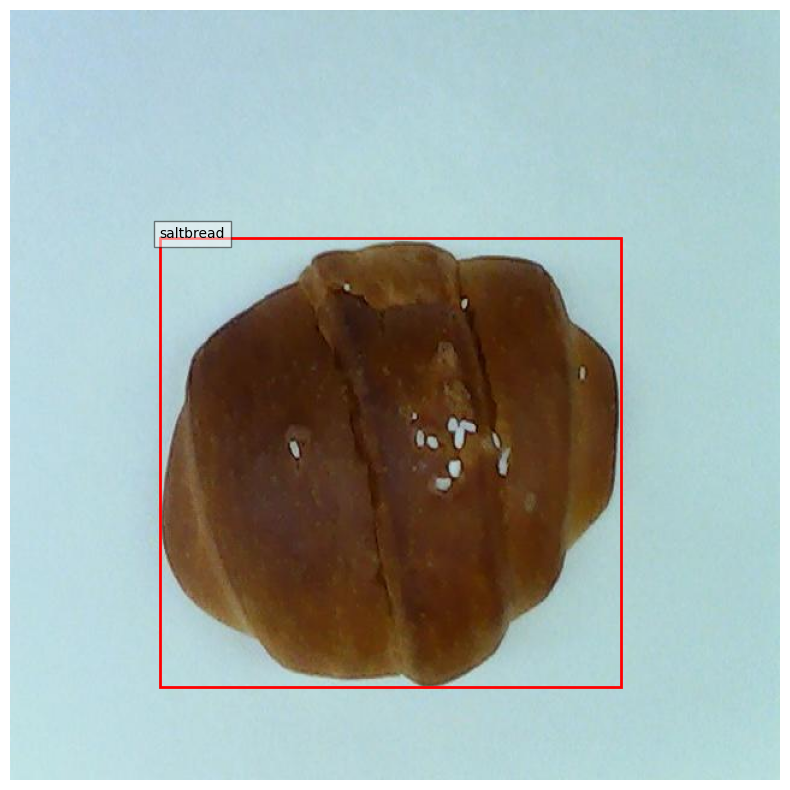

In [7]:
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 데이터 변환
transform = T.Compose([
    T.ToTensor(),
])

# 데이터셋 객체 생성
train_dataset = BreadDataset(root=dir, split='train', transform=transform)
valid_dataset = BreadDataset(root=dir, split='valid', transform=transform)
test_dataset = BreadDataset(root=dir, split='test', transform=transform)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# 클래스 이름 확인
classes = {v: k for k, v in train_dataset.categories.items()}
print("클래스 목록:", classes)

# 샘플 시각화
def visualize_sample(dataset, idx=0):
    img, target = dataset[idx]
    img_np = img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img_np)

    for box, label in zip(target['boxes'], target['labels']):
        x1, y1, x2, y2 = box.numpy()
        width = x2 - x1
        height = y2 - y1

        # 바운딩 박스 그리기
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # 클래스 이름 표시
        class_name = dataset.categories[label.item()]
        ax.text(x1, y1, class_name, bbox=dict(facecolor='white', alpha=0.5))

    plt.axis('off')
    plt.show()

# 예시 이미지 시각화
visualize_sample(train_dataset, idx=0)

In [8]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 모델 불러오기 (Pretrained)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# 클래스 수 설정 (배경 포함)
num_classes = len(train_dataset.categories) + 1  # 배경 포함
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# # GPU 사용 가능하면 이동
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# model.to(device)

# 모델 구조 출력
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 192MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [43]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def get_faster_rcnn_model(num_classes):
    # 사전 훈련된 ResNet50 FPN 백본을 사용한 Faster R-CNN 모델
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    # 분류기의 입력 특성 가져오기
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # 클래스 수에 맞는 새 분류기로 교체
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0

    for images, targets in data_loader:
        # 이미지와 타겟을 디바이스로 이동
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # 모델에 입력하여 손실 계산
        loss_dict = model(images, targets)

        # 손실들의 합 계산
        losses = sum(loss for loss in loss_dict.values())

        # 역전파
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    print(f"Epoch {epoch} Loss: {total_loss/len(data_loader):.4f}")
    return total_loss/len(data_loader)

def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # 평가 모드에서는 손실 계산 방식을 변경
            model.train()  # 일시적으로 train 모드로 변경
            loss_dict = model(images, targets)
            model.eval()  # 다시 eval 모드로 복귀

            # 손실이 딕셔너리인 경우 처리
            if isinstance(loss_dict, dict):
                losses = sum(loss for loss in loss_dict.values())
            elif isinstance(loss_dict, list):
                losses = sum(loss.sum() for loss in loss_dict)
            else:
                losses = loss_dict

            total_loss += losses.item()

    return total_loss/len(data_loader)

def train_model(model, train_loader, valid_loader, device, num_epochs=10):
    # 옵티마이저 설정
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    # 학습률 스케줄러
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    best_valid_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")

        # 훈련
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch+1)

        # 검증
        valid_loss = evaluate(model, valid_loader, device)

        # 학습률 조정
        lr_scheduler.step()

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Valid Loss: {valid_loss:.4f}")

        # 최고의 모델 저장
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_bread_detection_model.pth')
            print("모델 저장됨!")

    return model

def visualize_predictions(model, test_loader, device, num_images=4, conf_threshold=0.5):
    model.eval()

    fig, axes = plt.subplots(2, num_images, figsize=(20, 10))

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(test_loader):
            if batch_idx >= 1:  # 1개 배치만 처리
                break

            images = list(image.to(device) for image in images)
            predictions = model(images)

            for i, (image, pred) in enumerate(zip(images, predictions)):
                # 이미지를 CPU로 변환
                img_np = image.cpu().permute(1, 2, 0).numpy()

                axes[0, i].imshow(img_np)
                axes[0, i].set_title(f"Original Image {i+1}")
                axes[0, i].axis('off')

                axes[1, i].imshow(img_np)
                axes[1, i].set_title(f"Detected Objects {i+1}")

                # 예측된 바운딩 박스 시각화
                for box, score, label in zip(pred['boxes'], pred['scores'], pred['labels']):
                    if score > conf_threshold:
                        x1, y1, x2, y2 = box.cpu().numpy()
                        width = x2 - x1
                        height = y2 - y1

                        rect = patches.Rectangle((x1, y1), width, height,
                                                 linewidth=2, edgecolor='r', facecolor='none')
                        axes[1, i].add_patch(rect)

                        class_name = train_dataset.categories[label.item()]
                        axes[1, i].text(x1, y1, f"{class_name}: {score.item():.2f}",
                                         bbox=dict(facecolor='red', alpha=0.5))

                axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

def main():
    # 디바이스 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"현재 사용 디바이스: {device}")

    # 클래스 수 (배경 포함)
    num_classes = len(train_dataset.categories) + 1

    # 모델 생성
    model = get_faster_rcnn_model(num_classes)
    model.to(device)

    # 모델 학습
    trained_model = train_model(model, train_loader, valid_loader, device, num_epochs=10)

    # 테스트 데이터에 대한 예측 시각화
    visualize_predictions(trained_model, test_loader, device)

if __name__ == "__main__":
    main()

현재 사용 디바이스: cuda

--- Epoch 1/10 ---


ValueError: could not broadcast input array from shape (640,640,3) into shape (640,0,3)

## 추론

In [36]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as T

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 로드 함수
def load_model(model_path, num_classes):
    # 기본 Faster R-CNN 모델 불러오기
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

    # 분류기 수정
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # 저장된 가중치 불러오기
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    return model

# 이미지 전처리 함수
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    return transform(image).unsqueeze(0).to(device)  # 배치 차원 추가

# 결과 시각화 함수
def visualize_predictions(image_path, model, categories, conf_threshold=0.6):
    image = Image.open(image_path).convert("RGB")
    image_tensor = preprocess_image(image_path)

    with torch.no_grad():
        prediction = model(image_tensor)[0]  # 모델 추론

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
        if score > conf_threshold:
            x1, y1, x2, y2 = box.cpu().numpy()
            width, height = x2 - x1, y2 - y1

            # 바운딩 박스 그리기
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # 클래스 이름 표시
            class_name = categories.get(label.item(), "Unknown")
            ax.text(x1, y1, f"{class_name}: {score:.2f}", bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()


<ipython-input-36-1ed30dd55806>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


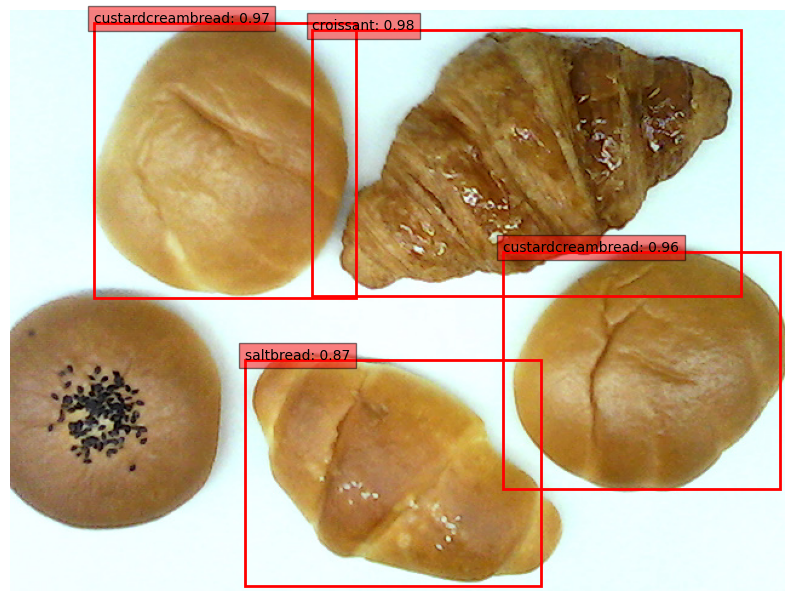

In [37]:
# 저장된 모델 불러오기
num_classes = len(train_dataset.categories) + 1  # 배경 포함
model_path = "/content/best_bread_detection_model.pth"
model = load_model(model_path, num_classes)

# 클래스 목록
categories = train_dataset.categories  # {ID: "class_name"}

# 테스트할 이미지 경로
test_image_path = "/content/test6.jpg"  # 실제 파일명으로 변경 필요

# 추론 및 시각화
visualize_predictions(test_image_path, model, categories)

# 성능평가

## iou 없는 버전

In [117]:
pip install torch torchvision matplotlib pillow

In [120]:
import os
import json
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm  # 진행률 표시

def load_model(model_path, num_classes, device):
    """Faster R-CNN 모델 로드"""
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict, strict=False)

    model.to(device)
    model.eval()
    return model

def calculate_iou(box1, box2):
    """IoU 계산"""
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

def calculate_map(predictions, ground_truths, iou_threshold=0.5):
    """mAP 계산"""
    tp, fp, total_gt = 0, 0, 0

    for pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels in zip(
        predictions['boxes'], predictions['scores'], predictions['labels'],
        ground_truths['boxes'], ground_truths['labels']):

        pred_boxes = pred_boxes[pred_scores > 0.5].cpu().numpy()
        pred_labels = pred_labels[pred_scores > 0.5].cpu().numpy()
        gt_boxes = gt_boxes.cpu().numpy()
        gt_labels = gt_labels.cpu().numpy()

        total_gt += len(gt_boxes)
        matched = set()

        for pred_box, pred_label in zip(pred_boxes, pred_labels):
            best_iou = 0
            best_match = -1

            for i, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):
                if gt_label == pred_label and i not in matched:
                    iou = calculate_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_match = i

            if best_iou >= iou_threshold:
                tp += 1
                matched.add(best_match)
            else:
                fp += 1

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / total_gt if total_gt > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    map_value = precision * recall  # 단순 mAP 근사치

    return {
        'IoU Threshold': iou_threshold,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'mAP': map_value
    }

def evaluate_model(model, test_loader, device):
    """모델 성능 평가"""
    results = {'boxes': [], 'scores': [], 'labels': []}
    gt_results = {'boxes': [], 'labels': []}

    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            predictions = model(images)

            for pred, target in zip(predictions, targets):
                results['boxes'].append(pred['boxes'])
                results['scores'].append(pred['scores'])
                results['labels'].append(pred['labels'])
                gt_results['boxes'].append(target['boxes'])
                gt_results['labels'].append(target['labels'])

    return calculate_map(results, gt_results)

class BreadDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, directory, annotation_path, transforms=None):
        """COCO 데이터셋 로드"""
        with open(annotation_path, 'r') as f:
            coco_annotations = json.load(f)

        self.image_info = []
        self.categories = {cat['id']: cat['name'] for cat in coco_annotations['categories']}
        self.categories[0] = 'background'  # 배경 클래스 추가

        for img in coco_annotations['images']:
            img_id = img['id']
            file_name = img['file_name']
            image_path = os.path.join(directory, file_name)

            anns = [ann for ann in coco_annotations['annotations'] if ann['image_id'] == img_id]
            if os.path.exists(image_path):
                self.image_info.append({'image_path': image_path, 'annotations': anns})

        self.transforms = transforms or transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.image_info)

    def __getitem__(self, idx):
        """이미지 로드"""
        img_info = self.image_info[idx]
        image = Image.open(img_info['image_path']).convert("RGB")

        boxes, labels = [], []
        for ann in img_info['annotations']:
            x1, y1, x2, y2 = ann['bbox'][0], ann['bbox'][1], ann['bbox'][0] + ann['bbox'][2], ann['bbox'][1] + ann['bbox'][3]
            boxes.append([x1, y1, x2, y2])
            labels.append(ann['category_id'])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        image = self.transforms(image)

        return image, {'boxes': boxes, 'labels': labels}

def main():
    """모델 평가 실행"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    directory = "/content/dataset/test"
    annotation_path = os.path.join(directory, "_annotations.coco.json")

    transform = transforms.Compose([transforms.ToTensor()])
    test_dataset = BreadDetectionDataset(directory, annotation_path, transform)

    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
    num_classes = len(test_dataset.categories) + 1
    model = load_model("/content/best_bread_detection_model.pth", num_classes, device)

    metrics = evaluate_model(model, test_loader, device)
    print("\n--- 모델 성능 지표 ---")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

if __name__ == "__main__":
    main()


<ipython-input-120-2f97e565d711>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)
Evaluating: 100%|██████████| 150/


--- 모델 성능 지표 ---
IoU Threshold: 0.5000
Precision: 0.9934
Recall: 1.0000
F1-Score: 0.9967
mAP: 0.9934


## iou 있는 버전

In [127]:
import os
import json
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm  # 진행률 표시

def load_model(model_path, num_classes, device):
    """Faster R-CNN 모델 로드"""
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict, strict=False)

    model.to(device)
    model.eval()
    return model

def calculate_iou(box1, box2):
    """IoU 계산"""
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

def calculate_map(predictions, ground_truths, iou_threshold=0.5):
    """mAP 계산"""
    tp, fp, total_gt = 0, 0, 0

    for pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels in zip(
        predictions['boxes'], predictions['scores'], predictions['labels'],
        ground_truths['boxes'], ground_truths['labels']):

        pred_boxes = pred_boxes[pred_scores > 0.5].cpu().numpy()
        pred_labels = pred_labels[pred_scores > 0.5].cpu().numpy()
        gt_boxes = gt_boxes.cpu().numpy()
        gt_labels = gt_labels.cpu().numpy()

        total_gt += len(gt_boxes)
        matched = set()

        for pred_box, pred_label in zip(pred_boxes, pred_labels):
            best_iou = 0
            best_match = -1

            for i, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):
                if gt_label == pred_label and i not in matched:
                    iou = calculate_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_match = i

            if best_iou >= iou_threshold:
                tp += 1
                matched.add(best_match)
            else:
                fp += 1

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / total_gt if total_gt > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    map_value = precision * recall  # 단순 mAP 근사치

    return {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'mAP': map_value
    }

def evaluate_model(model, test_loader, device):
    """모델 성능 평가 (Precision, Recall, F1-Score, mAP, Mean IoU)"""
    results = {'boxes': [], 'scores': [], 'labels': []}
    gt_results = {'boxes': [], 'labels': []}
    iou_list = []

    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            predictions = model(images)

            for pred, target in zip(predictions, targets):
                pred_boxes = pred['boxes'].cpu().numpy()
                pred_scores = pred['scores'].cpu().numpy()
                pred_labels = pred['labels'].cpu().numpy()
                gt_boxes = target['boxes'].cpu().numpy()
                gt_labels = target['labels'].cpu().numpy()

                results['boxes'].append(pred['boxes'])
                results['scores'].append(pred['scores'])
                results['labels'].append(pred['labels'])
                gt_results['boxes'].append(target['boxes'])
                gt_results['labels'].append(target['labels'])

                # IoU 계산
                for pred_box, pred_label in zip(pred_boxes, pred_labels):
                    iou_values = [
                        calculate_iou(pred_box, gt_box)
                        for gt_box, gt_label in zip(gt_boxes, gt_labels)
                        if gt_label == pred_label
                    ]
                    if iou_values:
                        iou_list.append(max(iou_values))

    metrics = calculate_map(results, gt_results)
    metrics['Mean IoU'] = np.mean(iou_list) if iou_list else 0.0

    return metrics


class BreadDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, directory, annotation_path, transforms=None):
        """COCO 데이터셋 로드"""
        with open(annotation_path, 'r') as f:
            coco_annotations = json.load(f)

        self.image_info = []
        self.categories = {cat['id']: cat['name'] for cat in coco_annotations['categories']}
        self.categories[0] = 'background'  # 배경 클래스 추가

        for img in coco_annotations['images']:
            img_id = img['id']
            file_name = img['file_name']
            image_path = os.path.join(directory, file_name)

            anns = [ann for ann in coco_annotations['annotations'] if ann['image_id'] == img_id]
            if os.path.exists(image_path):
                self.image_info.append({'image_path': image_path, 'annotations': anns})

        self.transforms = transforms or transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.image_info)

    def __getitem__(self, idx):
        """이미지 로드"""
        img_info = self.image_info[idx]
        image = Image.open(img_info['image_path']).convert("RGB")

        boxes, labels = [], []
        for ann in img_info['annotations']:
            x1, y1, x2, y2 = ann['bbox'][0], ann['bbox'][1], ann['bbox'][0] + ann['bbox'][2], ann['bbox'][1] + ann['bbox'][3]
            boxes.append([x1, y1, x2, y2])
            labels.append(ann['category_id'])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        image = self.transforms(image)

        return image, {'boxes': boxes, 'labels': labels}

def main():
    """모델 평가 실행"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    directory = "/content/dataset/test"
    annotation_path = os.path.join(directory, "_annotations.coco.json")

    transform = transforms.Compose([transforms.ToTensor()])
    test_dataset = BreadDetectionDataset(directory, annotation_path, transform)

    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
    num_classes = len(test_dataset.categories) + 1
    model = load_model("/content/best_bread_detection_model.pth", num_classes, device)

    metrics = evaluate_model(model, test_loader, device)
    print("\n--- 모델 성능 지표 ---")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

if __name__ == "__main__":
    main()


<ipython-input-127-bd1d2ecc3836>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)
Evaluating: 100%|██████████| 150/


--- 모델 성능 지표 ---
Precision: 0.9934
Recall: 1.0000
F1-Score: 0.9967
mAP: 0.9934
Mean IoU: 0.8275
